In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
%load_ext memory_profiler

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re


sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
module = fc.eightb.preselection.ranked_quadh

signal = ObjIter([Tree(fn) for fn in module.signal_list])
# signal = ObjIter([Tree(module.NMSSM_XYY_YToHH_8b_MX_1000_MY_450)])
# signal_asym = ObjIter([Tree(fc.eightb.preselection.NMSSM_XYY_YToHH_8b_MX_1000_MY_450)])
qcd = ObjIter([Tree(module.QCD_B_List)])
# qcd_asym = ObjIter([Tree(fc.eightb.preselection.QCD_B_List)])
ttbar = ObjIter([Tree(module.TTJets)])
# ttbar = ObjIter([])
# qcd = ObjIter([])

100%|██████████| 2/2 [00:01<00:00,  1.30it/s]


# Event Selection
## - Trigger applied | HLT_PFHT330PT30_QuadPFJet_75_60_45_40_TriplePFBTagDeepCSV_4p5
## - Required at least 8 jets to pass preselection
## - Preselections: Jet $P_{T} > 20$ [GeV], Jet $|\eta| < 2.5$, Tight Jet ID
## - Top 8 Btagged jets selected
## - Jets are paired into di-jets using the QuadHRanker Algorithm
## - Di-Jets are paired into Quad-Jets using by minimizing the mass difference between pairs

In [3]:
bkg = qcd + ttbar
bkg.reweight(2.3)
bkg.set_systematics([0.2])

[None, None]

# MC Reweighting
## MC Background normalization needs to be corrected to match data normalization
## A rough correction of 2.3x is applied along with a 20\% uncertainty

In [4]:
(signal + bkg).apply(lambda t : build_collection(t, 'H\dY\d', 'higgs', ptordered=True))

[None, None, None, None, None]

In [28]:
def higgs_shape(tree):
    sphericity = calc_sphericity(tree.higgs_pt, tree.higgs_eta, tree.higgs_phi, tree.higgs_m, njet=4)

    sphericity['aplanarity'] = np.log10(sphericity['aplanarity'])

    tree.extend(**sphericity)    

(signal+bkg).apply(higgs_shape)

[None, None, None, None, None]

100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


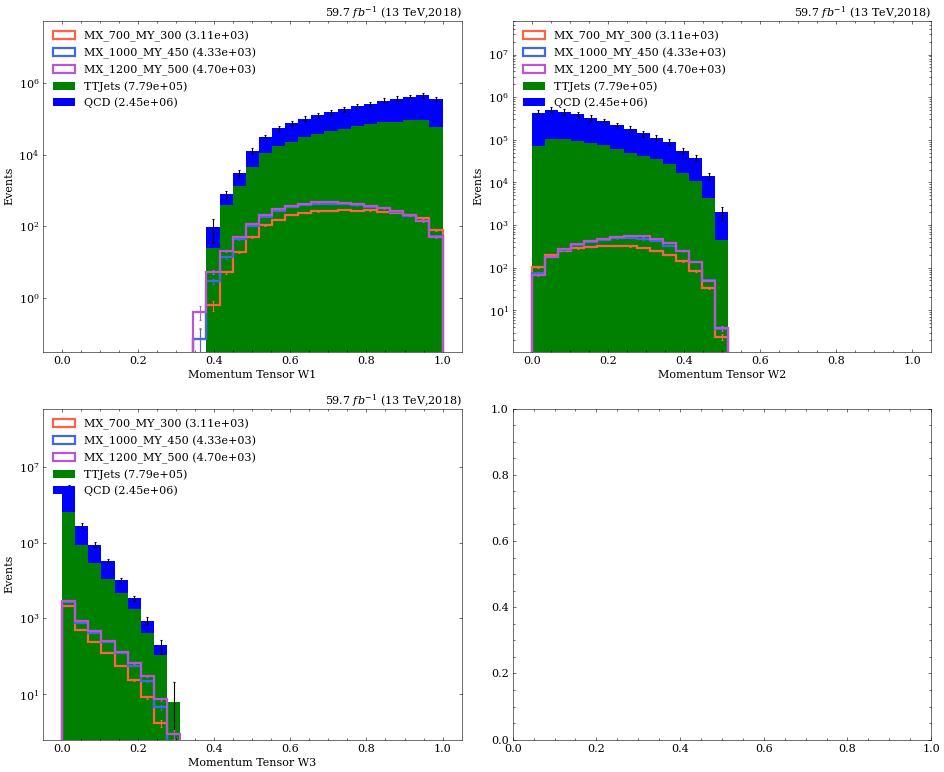

In [50]:
study.quick(
    signal+bkg, legend=True, log=True,
    varlist=['M_eig_w1','M_eig_w2','M_eig_w3'],
    # e_sf=True,
    # **study.auroc
)

100%|██████████| 1/1 [00:04<00:00,  4.59s/it]


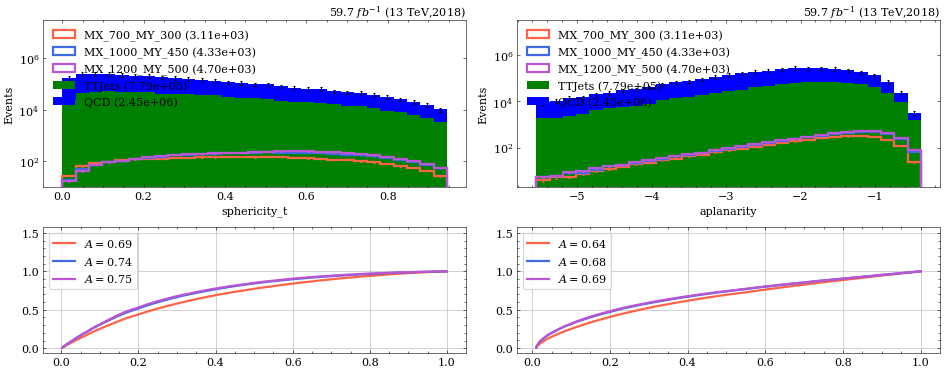

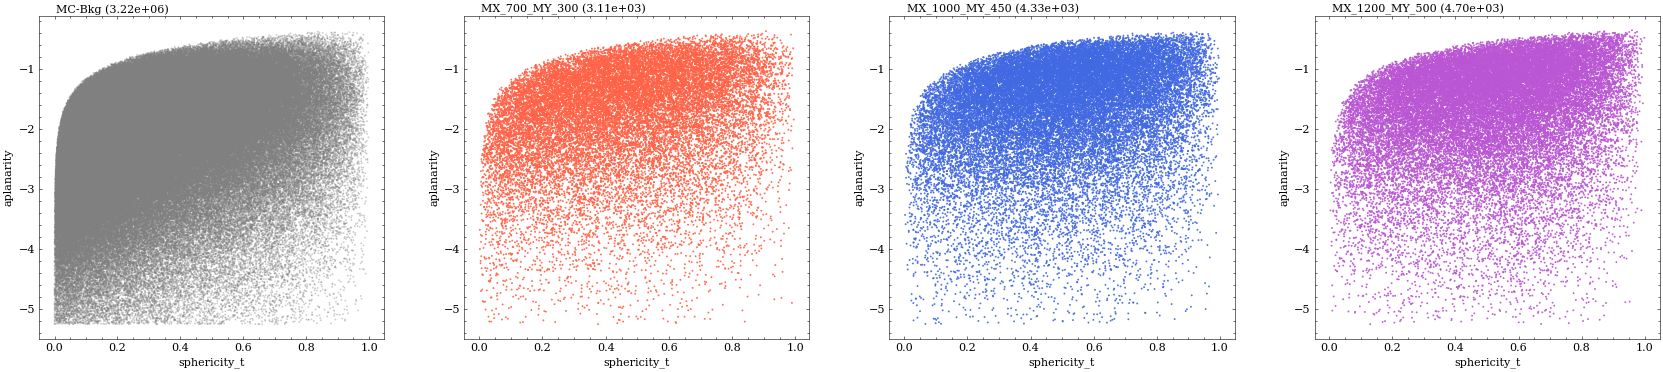

In [33]:
study.quick(
    signal+bkg, legend=True, log=True,
    varlist=['sphericity_t','aplanarity'],
    e_sf=True,
    **study.auroc
)
study.quick2d(
    signal+bkg, 
    varlist=['sphericity_t','aplanarity'],
    scatter=True,
)

In [51]:
bdt_classifier = BDTClassifier(features=['M_eig_w1','M_eig_w2','M_eig_w3'])

In [52]:
train_signal = signal.subset(nentries=20000) # train on randomly selected events from each signal tree: total_signal = n_signal_trees * nentries
train_bkg = bkg.subset(nentries=30000) # train on randomly selected events from each bkg tree: total_bkg = n_bkg_trees * nentries

bdt_classifier.train(train_bkg, train_signal)

In [53]:
test_signal = signal.subset(nentries=20000)
test_bkg = bkg.subset(nentries=30000)

bdt_classifier.print_results(test_bkg, test_signal)

--- BDT Classifier Results ---
AUROC = 0.759


In [54]:
bdt_higgs_m = BDTClassifier.load('bdt_resonant_mass_classifier')

In [55]:
(signal+bkg).apply(lambda t : t.extend(
    bdt_sphericity=bdt_classifier.predict_tree(t),
    bdt_higgs_m=bdt_higgs_m.predict_tree(t),
))

[None, None, None, None, None]

100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


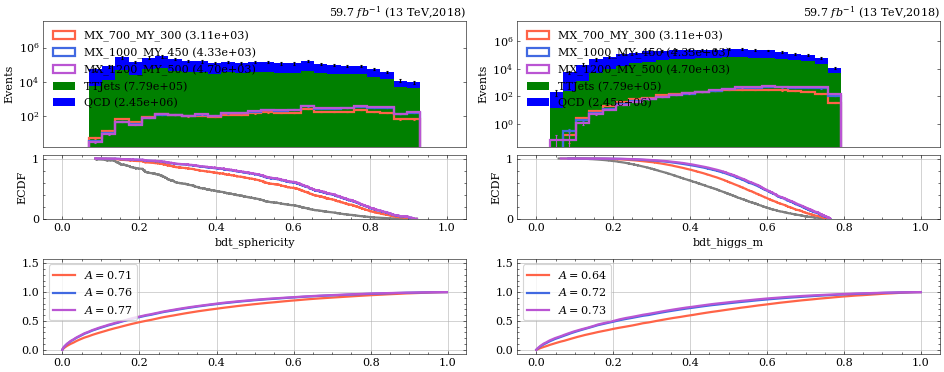

In [56]:
varinfo.bdt_sphericity = dict(bins=(0,1,30))
varinfo.bdt_higgs_m = dict(bins=(0,1,30))



study.quick(
    signal+bkg,
    varlist=['bdt_sphericity','bdt_higgs_m'],
    # efficiency=True,
    log=True, legend=True,
    
    e_sf=True,
    **dict(study.auroc, e_show=True),
)

100%|██████████| 1/1 [00:04<00:00,  4.64s/it]


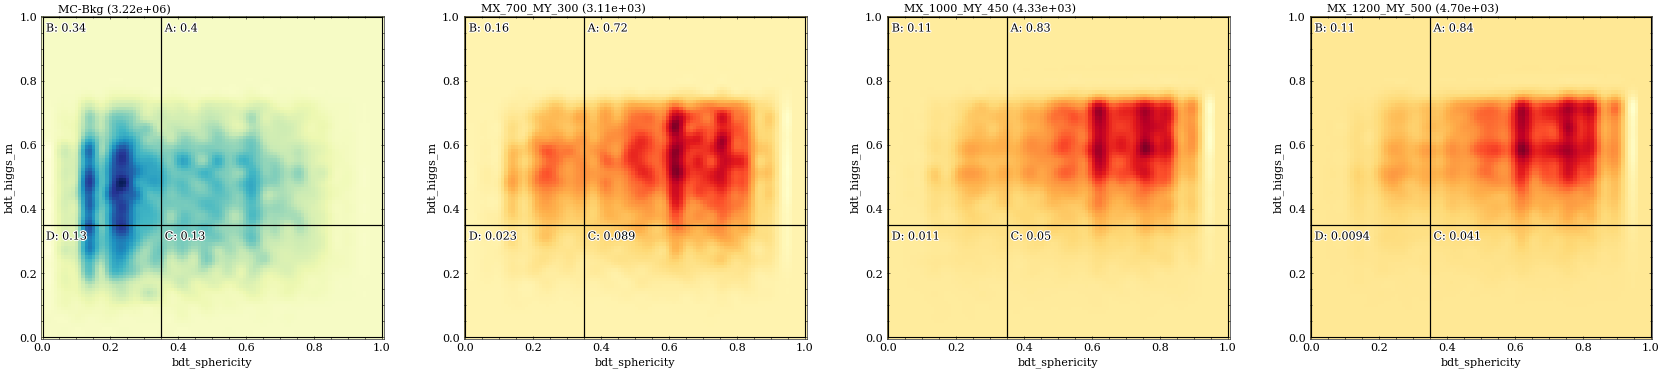

In [57]:
study.quick2d(
    signal+bkg,
    varlist=['bdt_sphericity','bdt_higgs_m'],
    # scatter=True,
    interp=True,
    exe=draw_abcd(x_r=(0,0.35,1),y_r=(0,0.35,1))
)

In [65]:
ar_bdt = ABCD(
    features=['X_m','X_pt','n_loose_btag'],
    a=lambda t : (t.bdt_sphericity > 0.35) & (t.bdt_higgs_m > 0.35),
    b=lambda t : (t.bdt_sphericity > 0.35) & (t.bdt_higgs_m < 0.35),
    c=lambda t : (t.bdt_sphericity < 0.35) & (t.bdt_higgs_m > 0.35),
    d=lambda t : (t.bdt_sphericity < 0.35) & (t.bdt_higgs_m < 0.35),
)

100%|██████████| 1/1 [00:21<00:00, 21.28s/it]


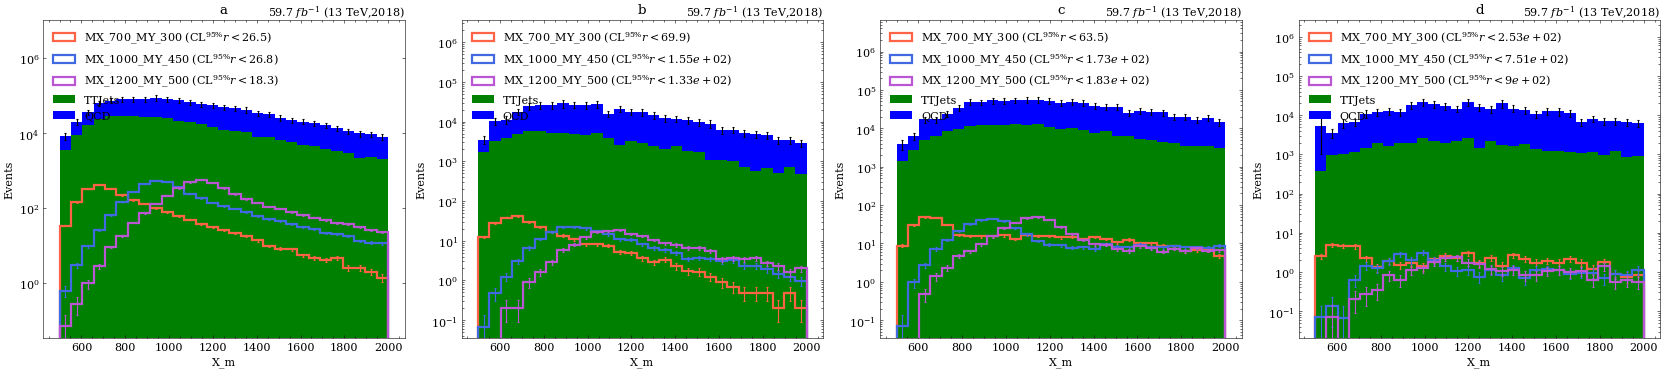

In [66]:
fig,axs=study.get_figax(4, dim=-1)
for i,region in enumerate(('a','b','c','d')):
    study.quick(
        signal+bkg, legend=True, log=True,
        masks=getattr(ar_bdt, region),
        varlist=['X_m'],
        title=region,
        limits=True,
        figax=(fig, axs.flat[i]),
    )

In [67]:
ar_bdt.train(bkg)
ar_bdt.print_results(bkg)

--- ABCD Results ---
k = 2.681e+00
k*(b/a)-1  = -10.06%
BDT(b)/a-1 = -2.69%



100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


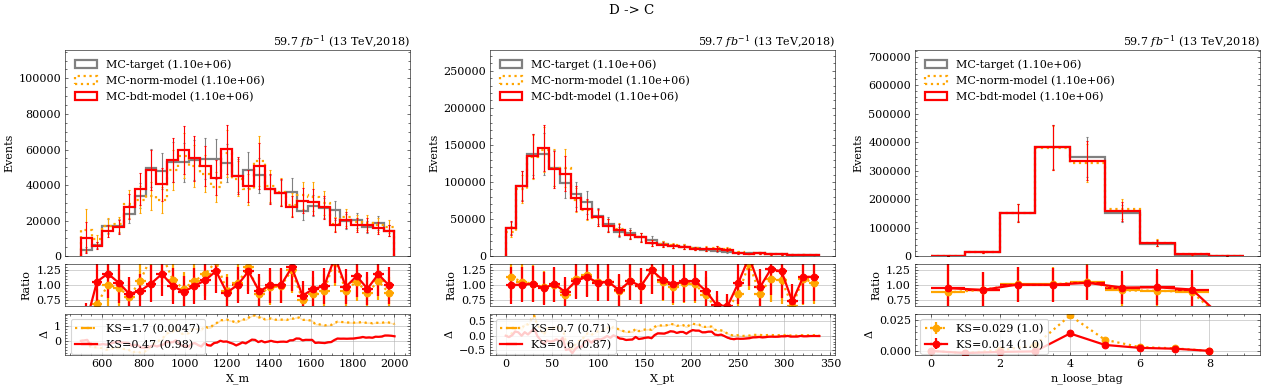

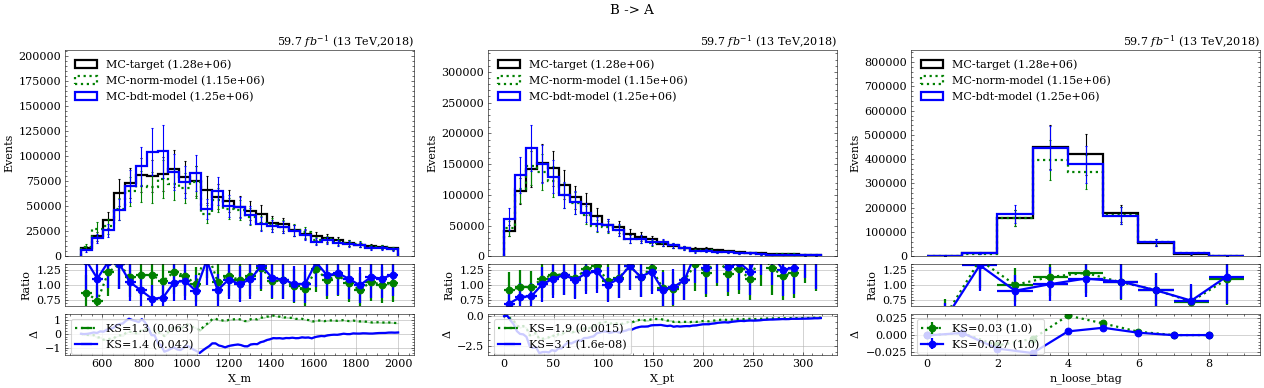

In [100]:
study.quick_region(
    bkg,bkg,bkg, legend=True, 
    h_color=['grey','orange','red'],
    h_linestyle=['-',':','-'],
    dim=-1,
    label=['MC-target','MC-norm-model','MC-bdt-model'],
    masks=[ar_bdt.c]*len(bkg)+[ar_bdt.d]*len(bkg)+[ar_bdt.d]*len(bkg),
    scale=[1]*len(bkg)+[ar_bdt.scale_tree]*len(bkg)+[ar_bdt.reweight_tree]*len(bkg),
    varlist=['X_m', 'X_pt','n_loose_btag'],
    ratio=True, r_ylim=(0.65,1.35), 
    **study.kstest,

    suptitle='D -> C',
    # saveas='mc_ar_DC'
)

study.quick_region(
    bkg,bkg,bkg, legend=True, 
    h_color=['black','green','blue'],
    h_linestyle=['-',':','-'],
    dim=-1,
    label=['MC-target','MC-norm-model','MC-bdt-model'],
    masks=[ar_bdt.a]*len(bkg)+[ar_bdt.b]*len(bkg)+[ar_bdt.b]*len(bkg),
    scale=[1]*len(bkg)+[ar_bdt.scale_tree]*len(bkg)+[ar_bdt.reweight_tree]*len(bkg),
    varlist=['X_m', 'X_pt','n_loose_btag'],
    ratio=True, r_ylim=(0.65,1.35),
    **study.kstest,

    suptitle='B -> A',
    # saveas='mc_ar_BA'
)